<a href="https://colab.research.google.com/github/kbharath21/SRISHTI_assignments/blob/main/iddsemantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SRISHTI - 24 IDD Dataset Semantic Segmentation**


**Introduction**

The task of semantic segmentation, a fundamental aspect of computer vision, involves dividing an image into meaningful segments to understand its content. It finds applications in various fields such as autonomous driving, medical imaging, and satellite imagery analysis. In this project, we focus on implementing a UNet architecture with a ResNet50 encoder for semantic segmentation tasks. By combining these architectures, we aim to develop an efficient model capable of accurately segmenting objects and regions of interest in images. Throughout this project, we will discuss data preprocessing, model construction, and training strategies to achieve optimal performance on our dataset.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.2.0-rc1
2.2.4-tf


In [ ]:
import warnings
from glob import glob
import gc
import cv2
import os
from tensorflow.keras import optimizers
import time
warnings.filterwarnings("ignore")
import time
import numpy as np
import seaborn as sns
import math
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Input, Dropout, add, BatchNormalization, Bidirectional, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

In [ ]:
path = r'C:\Users\kbkprojcts\srishti24\IDD'

### Loading the data and modelling

In [ ]:
dataset_path = ''
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'
img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

In [ ]:
def VisualizeSegmentationImages(imagepath):
  img_seg = cv2.imread(imagepath,0)

  for i in range(len(img_seg)):
    for j in range(len(img_seg[0])):
        if img_seg[i][j] != 0 or img_seg[i][j] != 255:

            img_seg[i][j] *= 40
  plt.imshow(img_seg)


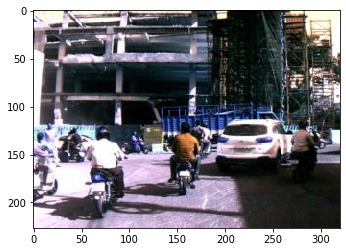

In [ ]:
img = cv2.imread(img_train+'0/024541_image.jpg',1)
plt.imshow(img)

**Masking**

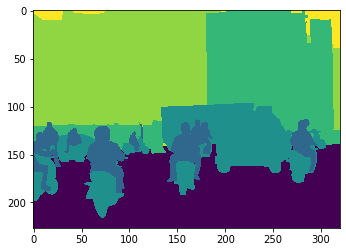

In [ ]:
img_seg = VisualizeSegmentationImages(seg_train+'0/024541_label.png')

In [ ]:
dataset_path = 'F:\SRISHTI24\IDDSemanticSegmentation\SemanticSegmentation'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'


img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

In [ ]:
mi, ma = 0,7
n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))


minimum seg = 0, maximum seg = 7, Total number of segmentation classes = 8


In [ ]:

def load_image_paths_from_folder(folder_path):
  image_paths = glob(folder_path+'*/*_image.jpg')
  return image_paths


In [ ]:
x_train, y_train = [] , []
x_val , y_val = [] , []

In [ ]:
input_height , input_width = 128 , 256
output_height , output_width = 128 , 256

In [ ]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 255
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]
    img[img == 255] = 7

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    #print(seg_labels[:,:,6])
    return seg_labels




In [ ]:
train_image_paths = load_image_paths_from_folder(img_train)
train_seg_paths = [p.replace('leftImg8bit', 'gtFine').replace(
    '_image.jpg', '_label.png') for p in train_image_paths]
val_image_paths = load_image_paths_from_folder(img_val)
val_seg_paths = [p.replace('leftImg8bit', 'gtFine').replace(
    '_image.jpg', '_label.png') for p in val_image_paths]

from numpy.random import seed
seed(0)
def image_generator(image_paths, batch_size=32):
    while True:
          num_samples = len(image_paths)
          for offset in range(0, num_samples, batch_size):
            batch_paths = image_paths[offset:offset+batch_size]
            batch_input  = []
            batch_output = []
            for input_path in batch_paths:
                image = getImageArr(input_path,input_width,input_height)
                seg_path = input_path.replace('leftImg8bit', 'gtFine').replace(\
                  '_image.jpg', '_label.png')
                seg_mask = getSegmentationArr(seg_path,n_classes,output_width,output_height)

                batch_input.append(image)
                batch_output.append(seg_mask)
            batch_x = np.array( batch_input )
            batch_y = np.array( batch_output )
            yield( batch_x, batch_y )

**Using Custom Generator to Load Data Batch Wise**

When dealing with large datasets, custom generators offer an efficient solution by loading data in manageable batches. This approach minimizes memory usage and enables on-the-fly preprocessing. Particularly useful for real-world cases, it allows for iterative processing and training. Custom generators are essential for tasks involving extensive datasets like images, audio, or text. They facilitate incremental training and enhance overall efficiency in machine learning workflows.

In [ ]:
train_gen = image_generator(train_image_paths, batch_size = 32)
val_gen = image_generator(val_image_paths,batch_size=32)

In [ ]:
def get_image_and_segmentation_arrays(img_path,seg_path):
  X, Y= [],[]
  for img , seg in zip(img_path, seg_path):
    X.append(getImageArr(img,input_width,input_height))
    Y.append(getSegmentationArr(seg,n_classes,output_width,output_height))
  return X,Y


#### If you want to preprocess all the train, validation data at once and use it for training use this section(Not ideal in real world)

#### This works when you have large RAM to store the entire processed data

In [ ]:
# This block is for reusing alrady computed Image arrays as it takes considerable amount of time to genetate them
# If using this block we can skip the next two blocks

## loading from file
# %%time
# x_train = np.load(dataset_path+"x_train.npy")
# y_train = np.load(dataset_path+"y_train.npy")

# x_val = np.load(dataset_path+"x_val.npy")
# y_val = np.load(dataset_path+"y_val.npy")

CPU times: user 105 ms, sys: 4.09 s, total: 4.19 s
Wall time: 2min 5s


In [ ]:
# %%time

# x_train , y_train = get_image_and_segmentation_arrays(train_image_paths,train_seg_paths)

CPU times: user 6.97 s, sys: 1.85 s, total: 8.83 s
Wall time: 15.2 s


In [ ]:
#%%time

#x_val , y_val = get_image_and_segmentation_arrays(val_image_paths,val_seg_paths)

CPU times: user 980 ms, sys: 349 ms, total: 1.33 s
Wall time: 2min 4s


In [ ]:

# # saving these results to avoid processing everytime

# x_train_path = dataset_path+"x_train.npy"
# y_train_path = dataset_path+"y_train.npy"

# x_val_path = dataset_path+"x_val.npy"
# y_val_path = dataset_path+"y_val.npy"


# np.save(x_train_path,x_train)
# np.save(y_train_path,y_train)
# np.save(x_val_path,x_val)
# np.save(y_val_path,y_val)

In [ ]:
#x_train, y_train = np.array(x_train), np.array(y_train)
#x_val, y_val = np.array(x_val),np.array(y_val)

In [ ]:
#print(x_train.shape, y_train.shape)
#print(x_val.shape, y_val.shape)

(1403, 128, 256, 3) (1403, 128, 256, 8)
(204, 128, 256, 3) (204, 128, 256, 8)


### Leveraging ResNet50 in UNet for Semantic Segmentation

By integrating ResNet50 as the encoder in the UNet architecture, we harness the comprehensive feature extraction capabilities of ResNet50 to enhance semantic segmentation accuracy. This fusion combines the contextual understanding of UNet with the deep representation learning of ResNet50, resulting in a powerful model that excels in capturing both low-level and high-level features essential for accurate segmentation.

In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name = conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding = 'same', name = conv_name_base + '2b')(x)
    x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name = conv_name_base + '2c')(x)
    x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu',name='activation_'+str(stage)+block)(x)

    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides = (2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides = strides, name = conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding = 'same', name = conv_name_base + '2b')(x)

    x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name = conv_name_base + '2c')(x)
    x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides = strides,
                      name = conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis = bn_axis, name = bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [ ]:

 """
    Instantiates the ResNet50 architecture with pre-trained weights from ImageNet.

    Parameters:
        input_tensor: Optional Keras tensor (i.e. output of `layers.Input()`) to use as input for the model.
        input_shape: Optional shape tuple, only to be specified if `include_top` is False.
        pooling: Optional pooling mode for feature extraction when `include_top` is False.
        classes: Optional number of classes to classify images into, only to be specified if `include_top` is True.

    Returns:
        A Keras model instance.
    """


def ResNet50(input_tensor = None, input_shape = None, pooling = None, classes = 1000):
    img_input = Input(shape = input_shape)
    bn_axis = 3

    x = Conv2D(64, (7, 7), strides = (2, 2), padding = 'same', name = 'conv1',kernel_initializer="he_normal" )(img_input)
    x = BatchNormalization(axis = bn_axis, name = 'bn_conv1')(x)
    x = Activation('relu',name="activation_1")(x)

    x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage = 2, block = 'a', strides = (1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage = 2, block = 'b')

    x = identity_block(x, 3, [64, 64, 256], stage = 2, block = 'c')

    x = conv_block(x, 3, [128, 128, 512], stage = 3, block = 'a')
    x = identity_block(x, 3, [128, 128, 512], stage = 3, block = 'b')
    x = identity_block(x, 3, [128, 128, 512], stage = 3, block = 'c')
    x = identity_block(x, 3, [128, 128, 512], stage = 3, block = 'd')

    x = conv_block(x, 3, [256, 256, 1024], stage = 4, block = 'a')
    x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'b')
    x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'c')
    x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'd')
    x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'e')
    x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'f')


    x = conv_block(x, 3, [512, 512, 2048], stage = 5, block = 'a')
    x = identity_block(x, 3, [512, 512, 2048], stage = 5, block = 'b')
    x = identity_block(x, 3, [512, 512, 2048], stage = 5, block = 'c')

    model = Model(img_input, x, name = 'resnet50')
    resnet50_weights_path = dataset_path+'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model.load_weights(resnet50_weights_path)


    return model


In [ ]:
def conv_block_bn(prevlayer, filters, prefix, strides = (1, 1)):
    conv = Conv2D(filters, (3, 3), padding = "same", kernel_initializer = "he_normal", strides = strides, name = prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name = prefix + "_bn")(conv)
    conv = Activation('relu', name = prefix + "_activation")(conv)

    return conv

In [ ]:
def unet_resnet(nClasses, input_shape):
    resnet_base = ResNet50(input_shape = input_shape)

    for l in resnet_base.layers:
        l.trainable = True

    conv1 = resnet_base.get_layer("activation_1").output
    conv2 = resnet_base.get_layer("activation_2c").output
    conv3 = resnet_base.get_layer("activation_3d").output
    conv4 = resnet_base.get_layer("activation_4f").output
    conv5 = resnet_base.get_layer("activation_5c").output

    up6 = concatenate([UpSampling2D()(conv5), conv4], axis = -1)
    conv6 = conv_block_bn(up6, 256, "conv6_1")
    conv6 = conv_block_bn(conv6, 256, "conv6_2")

    up7 = concatenate([UpSampling2D()(conv6), conv3], axis = -1)
    conv7 = conv_block_bn(up7, 64, "conv7_1")
    conv7 = conv_block_bn(conv7, 64, "conv7_2")
    up8 = concatenate([UpSampling2D()(conv7), conv2], axis = -1)
    conv8 = conv_block_bn(up8, 16, "conv8_1")
    conv8 = conv_block_bn(conv8, 16, "conv8_2")

    up9 = concatenate([UpSampling2D()(conv8), conv1], axis = -1)
    conv9 = conv_block_bn(up9, 8, "conv9_1")
    conv9 = conv_block_bn(conv9, 8, "conv9_2")


    up10 = UpSampling2D()(conv9)
    conv10 = conv_block_bn(up10, nClasses, "conv10_1")
    conv10 = conv_block_bn(conv10, nClasses, "conv10_2")
    conv10 = SpatialDropout2D(0.2)(conv10)

    x = Conv2D(nClasses, kernel_size = (1, 1), strides = (1, 1), activation = "softmax", name = "prediction")(conv10)
    model = Model(resnet_base.input, x)

    return model


 '''
 def unet_resnet(nClasses, input_shape):
    resnet_base = ResNet50(input_shape = input_shape)

    for l in resnet_base.layers:
        l.trainable = True

    # Corrected layer names
    conv1 = resnet_base.get_layer("activation_1").output
    conv2 = resnet_base.get_layer("activation_10").output
    conv3 = resnet_base.get_layer("activation_22").output
    conv4 = resnet_base.get_layer("activation_40").output
    conv5 = resnet_base.get_layer("activation_49").output

    up6 = concatenate([UpSampling2D()(conv5), conv4], axis = -1)
    conv6 = conv_block_bn(up6, 256, "conv6_1")
    conv6 = conv_block_bn(conv6, 256, "conv6_2")

    up7 = concatenate([UpSampling2D()(conv6), conv3], axis = -1)
    conv7 = conv_block_bn(up7, 64, "conv7_1")
    conv7 = conv_block_bn(conv7, 64, "conv7_2")
    up8 = concatenate([UpSampling2D()(conv7), conv2], axis = -1)
    conv8 = conv_block_bn(up8, 16, "conv8_1")
    conv8 = conv_block_bn(conv8, 16, "conv8_2")

    up9 = concatenate([UpSampling2D()(conv8), conv1], axis = -1)
    conv9 = conv_block_bn(up9, 8, "conv9_1")
    conv9 = conv_block_bn(conv9, 8, "conv9_2")

    up10 = UpSampling2D()(conv9)
    conv10 = conv_block_bn(up10, nClasses, "conv10_1")
    conv10 = conv_block_bn(conv10, nClasses, "conv10_2")
    conv10 = SpatialDropout2D(0.2)(conv10)

    x = Conv2D(nClasses, kernel_size = (1, 1), strides = (1, 1), activation = "softmax", name = "prediction")(conv10)
    model = Model(resnet_base.input, x)

    return model
'''


In [ ]:
model = unet_resnet(nClasses = n_classes, input_shape = (input_height, input_width, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 128, 64)  9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 128, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 128, 64)  0           bn_conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
filepath = dataset_path+"unet_keras_img_generator_adam.h5"

checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                            mode="min",
                            min_delta = 0,
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta = 0.0001)


logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#callbacks = [checkpoint, earlystop , reduce_lr]
callbacks = [checkpoint, earlystop , reduce_lr,tensorboard_callback]


In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr = 1e-2)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

In [ ]:
hist2 = model.fit_generator(train_gen, steps_per_epoch = (np.ceil(len(train_image_paths)/32)),
                  validation_data=val_gen, validation_steps=(np.ceil(len(val_image_paths)/32)),
                   callbacks=callbacks,
                   epochs = 50, verbose = 1)

Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 7/44 [===>..........................] - ETA: 19:39 - loss: 11.2799 - acc: 0.3081
Epoch 00001: val_loss improved from inf to 11.27992, saving model to /content/gdrive/My Drive/AppliedAI Dataset/IDD Casestudy/idd20k_lite/unet_keras_img_generator_adam.h5
44/44 [==============================] - 1818s 41s/step - loss: 1.5112 - acc: 0.4878 - val_loss: 11.2799 - val_acc: 0.3081
Epoch 2/50
 7/44 [===>..........................] - ETA: 14s - loss: 12.7994 - acc: 0.2072
Epoch 00002: val_loss did not improve from 11.27992
44/44 [==============================] - 36s 827ms/step - loss: 1.0439 - acc: 0.6935 - val_loss: 12.7994 - val_acc: 0.2072
Epoch 3/50
 7/44 [===>..........................] - ETA: 14s - loss: 4.2557 - acc: 0.4684
Epoch 00003: val_loss improved from 11.27992 to 4.25574, saving model to /content/gdrive/My Drive/AppliedAI Dataset/IDD Casestudy/idd20k_lite/unet_keras_img_genera

In [ ]:
filepath = dataset_path+"unet_keras_img_generator_adam_2.h5"

checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                            mode="min",
                            min_delta = 0,
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta = 0.0001)
#logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#callbacks = [checkpoint, earlystop , reduce_lr,tensorboard_callback]
callbacks = [checkpoint, earlystop , reduce_lr]


In [ ]:
adam = optimizers.Adam(lr = 2e-4)

model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

In [ ]:
model.load_weights(dataset_path+'unet_keras_img_generator_adam.h5')
hist2 = model.fit_generator(train_gen, steps_per_epoch = (np.ceil(len(train_image_paths)/32)),
                  validation_data=val_gen, validation_steps=(np.ceil(len(val_image_paths)/32)),
                   callbacks=callbacks,
                   epochs = 50, verbose = 1)

**Experimenting with Further Reduction of Learning Rate**

In an attempt to enhance model performance, the learning rate is being reduced even further to explore potential improvements in training outcomes.

In [ ]:
filepath = dataset_path+"unet_keras_img_generator_batch_adam_3.h5"

checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


earlystop = EarlyStopping(monitor = 'val_loss',
                            mode="min",
                            min_delta = 0,
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta = 0.0001)


#logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#callbacks = [checkpoint, earlystop , reduce_lr,tensorboard_callback]
callbacks = [checkpoint, earlystop , reduce_lr]

'''
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(
        filepath=dataset_path + "unet_keras_img_generator_batch_adam_3.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        mode="min",
        min_delta=0,
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        min_delta=0.0001
    )
]


'''

In [ ]:
adam = optimizers.Adam(lr = 5e-4)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

In [ ]:
model.load_weights(dataset_path+'unet_keras_img_generator_adam_2.h5')
hist2 = model.fit_generator(train_gen, steps_per_epoch = (np.ceil(len(train_image_paths)/25)),
                  validation_data=val_gen, validation_steps=(np.ceil(len(val_image_paths)/25)),
                   callbacks=callbacks,
                   epochs = 50, verbose = 1)

### Extra steps to tune further

In [ ]:

filepath = dataset_path+"unet_keras_img_generator_batch_adam_33_v2.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                            mode="min",
                            min_delta = 0,
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta = 0.0001)

#logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#callbacks = [checkpoint, earlystop , reduce_lr,tensorboard_callback]
callbacks = [checkpoint, earlystop , reduce_lr]


In [ ]:
adam = optimizers.Adam(lr = 1e-3)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

In [ ]:


hist2 = model.fit_generator(train_gen, steps_per_epoch = (np.ceil(len(train_image_paths)/32)),
                  validation_data=val_gen, validation_steps=(np.ceil(len(val_image_paths)/32)),
                   callbacks=callbacks,
                   epochs = 50, verbose = 1)


### Adjusting Learning Rate for Improved Results

The learning rate is being decreased in an effort to determine if it leads to enhanced performance during training.

In [ ]:

filepath = dataset_path+"unet_keras_img_generator_batch_adam_2_v2.h5"


checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                            mode="min",
                            min_delta = 0,
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta = 0.0001)


logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [checkpoint, earlystop , reduce_lr,tensorboard_callback]
#callbacks = [checkpoint, earlystop , reduce_lr]


In [ ]:
from tensorflow.keras import optimizers

adam = optimizers.Adam(lr = 2e-4)

model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

In [ ]:

hist2 = model.fit_generator(train_gen, steps_per_epoch = (np.ceil(len(train_image_paths)/32)),
                  validation_data=val_gen, validation_steps=(np.ceil(len(val_image_paths)/32)),
                   callbacks=callbacks,
                   epochs = 50, verbose = 1)

In [ ]:
model.load_weights(dataset_path+'unet_keras_img_generator_batch_adam_2_v2.h5')



In [ ]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = 7
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c))
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))


In [ ]:

x_val , y_val = get_image_and_segmentation_arrays(val_image_paths,val_seg_paths)

In [ ]:
x_val , y_val = np.array(x_val) , np.array(y_val)

In [ ]:
x_val.shape , y_val.shape

((204, 128, 256, 3), (204, 128, 256, 8))

In [ ]:
y_pred = model.predict(x_val)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_val, axis=3)
print(y_testi.shape,y_predi.shape)


(204, 128, 256) (204, 128, 256)


In [ ]:
IoU(y_testi,y_predi)

class 00: #TP=2042313, #FP=103753, #FN=64647, IoU=0.924
class 01: #TP= 77596, #FP= 68099, #FN=95316, IoU=0.322
class 02: #TP= 41737, #FP= 16540, #FN=85096, IoU=0.291
class 03: #TP=454668, #FP= 96868, #FN=118377, IoU=0.679
class 04: #TP=418813, #FP=267093, #FN=379605, IoU=0.393
class 05: #TP=1397542, #FP=364254, #FN=182835, IoU=0.719
class 06: #TP=1292264, #FP= 43132, #FN=33236, IoU=0.944
_________________
Mean IoU: 0.610


### mIoU on Train data


Calculating the mean Intersection over Union (mIoU) provides a measure of segmentation accuracy across all classes on the training dataset. This metric helps evaluate the effectiveness of the segmentation model during the training process.

In [ ]:
%%time

x_train , y_train = get_image_and_segmentation_arrays(train_image_paths,train_seg_paths)

CPU times: user 7.72 s, sys: 3.15 s, total: 10.9 s
Wall time: 13min 47s


In [ ]:
x_train , y_train = np.array(x_train) , np.array(y_train)

In [ ]:
x_train.shape ,y_train.shape

((1403, 128, 256, 3), (1403, 128, 256, 8))

In [ ]:
y_pred = model.predict(x_train)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_train, axis=3)
print(y_testi.shape,y_predi.shape)

(1403, 128, 256) (1403, 128, 256)


In [ ]:
# adam_opt

IoU(y_testi,y_predi)

class 00: #TP=14529519, #FP=417652, #FN=235653, IoU=0.957
class 01: #TP=710311, #FP=242550, #FN=373027, IoU=0.536
class 02: #TP=281124, #FP= 70864, #FN=460316, IoU=0.346
class 03: #TP=3242252, #FP=359370, #FN=489050, IoU=0.793
class 04: #TP=3852890, #FP=1010278, #FN=1295666, IoU=0.626
class 05: #TP=11283402, #FP=1347228, #FN=643220, IoU=0.850
class 06: #TP=8411427, #FP=214637, #FN=163210, IoU=0.957
_________________
Mean IoU: 0.723


### Generating segmentation maps for test data


In [ ]:

img_test = dataset_path+'leftImg8bit/test/'

test_image_paths = load_image_paths_from_folder(img_test)
test_seg_paths = [p.replace('leftImg8bit/test', 'output').replace(
    '_image.jpg', '_label.png') for p in test_image_paths]

In [ ]:
test_seg_dirs = [p.replace(p.split('/')[-1],'' ) for p in test_seg_paths]

In [ ]:
x_test=[]

for img_path  in test_image_paths:
    x_test.append(getImageArr(img_path,input_width,input_height))

In [ ]:
x_test = np.array(x_test)


In [ ]:
x_test.shape

(404, 128, 256, 3)

In [ ]:
y_out = model.predict(x_test)
y_outi = np.argmax(y_out, axis=3)
print(y_outi.shape,y_out.shape)

(404, 128, 256) (404, 128, 256, 8)


In [ ]:
#model used: unet_keras_img_generator_batch_adam_2_v2: cv - 0.610

for i in range(len(test_seg_paths)):
  if not os.path.exists(test_seg_dirs[i]):
    os.makedirs(test_seg_dirs[i])
  cv2.imwrite(test_seg_paths[i],y_outi[i])

### Testing

In [ ]:
for i in range(len(y)):
    for j in range(len(y[0])):
        if y[i][j] != 0 or y[i][j] != 255:
            y[i][j] *= 40


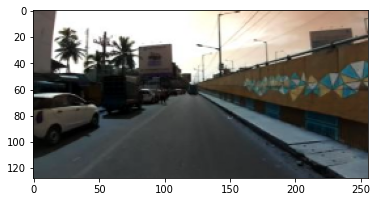

In [ ]:
plt.imshow(x_test[3])

In [ ]:
y = y_outi[3]

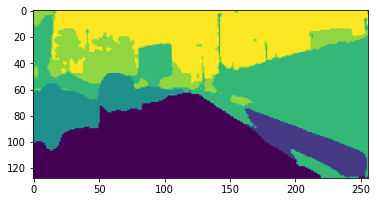

In [ ]:
plt.imshow(y)